# Creation of dataframe for gravity model

- join on cityname
- create city dataframe (nodes)
- create separate city-pairs dataframes (basically edges)
- calculate distances

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
from shapely.geometry import Point, LineString, Polygon

In [3]:
INDIR = "../../input"
OUTDIR = "../../output"
DATADIR = "../../../../data"
FILE_cities = "List_of_cities_300k.csv"
FILE_coords = "euro-global-map-shp/data/FullEurope/BuiltupP.shp" #path/to/shapefile
FILE_enpair = "citypairs_en.csv"
FILE_frpair = "citypairs_fr.csv"


In [4]:
# load the nodes dataset
fp = os.path.join(INDIR, "nodes.shp")
gdf = gpd.read_file(fp)

# load the pairs datasets
pairs_df_en = pd.read_csv(os.path.join(OUTDIR, FILE_enpair))
pairs_df_fr = pd.read_csv(os.path.join(OUTDIR, FILE_frpair))

### Edges

In [5]:
gdf.head()

,Mua_en,POP,CC,WEST,SOUTH,NORTH,CEAST,REGION,EN_DUM,FR_DUM,geometry
0,Utrecht,390,NL,1,0,0,0,west,0,0,POINT (5.11148 52.09863)
1,Eindhoven,316,NL,1,0,0,0,west,0,0,POINT (5.47234 51.45709)
2,Amsterdam,1052,NL,1,0,0,0,west,0,0,POINT (4.87429 52.37074)
3,Rotterdam,1025,NL,1,0,0,0,west,0,0,POINT (4.47374 51.92364)
4,Poznan,679,PL,0,0,0,1,central_east,0,0,POINT (16.91751 52.40734)


<AxesSubplot:>

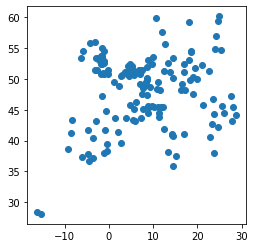

In [6]:
gdf.plot()

In [7]:
gdf = gdf.to_crs('EPSG:3035')
gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

### Create Edges

In [8]:
pairs_df_en.head()

,city_A,city_B,col_en
0,Paris,London,21874.0
1,Paris,Madrid,3394.0
2,Paris,Berlin,7899.0
3,Paris,Milan,3342.0
4,Paris,Barcelona,2397.0


In [9]:
# remove accents from names to enable join
gdf['Mua_en'] = [unidecode.unidecode(city) for city in gdf['Mua_en']]

In [10]:
# join first city
df = pd.merge(pairs_df_en, gdf, how='left', left_on = 'city_A', right_on = 'Mua_en')

In [11]:
df.shape

(11325, 14)

In [12]:
df.head()

,city_A,city_B,col_en,Mua_en,POP,CC,WEST,SOUTH,NORTH,CEAST,REGION,EN_DUM,FR_DUM,geometry
0,Paris,London,21874.0,Paris,9591,FR,1,0,0,0,west,0,1,POINT (3760015.368 2889948.695)
1,Paris,Madrid,3394.0,Paris,9591,FR,1,0,0,0,west,0,1,POINT (3760015.368 2889948.695)
2,Paris,Berlin,7899.0,Paris,9591,FR,1,0,0,0,west,0,1,POINT (3760015.368 2889948.695)
3,Paris,Milan,3342.0,Paris,9591,FR,1,0,0,0,west,0,1,POINT (3760015.368 2889948.695)
4,Paris,Barcelona,2397.0,Paris,9591,FR,1,0,0,0,west,0,1,POINT (3760015.368 2889948.695)


In [13]:
# join second city
df = pd.merge(df, gdf, how='left', left_on = 'city_B', right_on = 'Mua_en', suffixes=('_A', '_B'))

In [14]:
df.head()

,city_A,city_B,col_en,Mua_en_A,POP_A,CC_A,WEST_A,SOUTH_A,NORTH_A,CEAST_A,...,POP_B,CC_B,WEST_B,SOUTH_B,NORTH_B,CEAST_B,REGION_B,EN_DUM_B,FR_DUM_B,geometry_B
0,Paris,London,21874.0,Paris,9591,FR,1,0,0,0,...,8256,UK,1,0,0,0,west,1,0,POINT (3623219.566 3204183.954)
1,Paris,Madrid,3394.0,Paris,9591,FR,1,0,0,0,...,4955,ES,0,1,0,0,south,0,0,POINT (3161798.324 2030549.871)
2,Paris,Berlin,7899.0,Paris,9591,FR,1,0,0,0,...,3776,DE,1,0,0,0,west,0,0,POINT (4552085.153 3273010.955)
3,Paris,Milan,3342.0,Paris,9591,FR,1,0,0,0,...,3698,IT,0,1,0,0,south,0,0,POINT (4256391.191 2484870.286)
4,Paris,Barcelona,2397.0,Paris,9591,FR,1,0,0,0,...,3659,ES,0,1,0,0,south,0,0,POINT (3664331.118 2067683.425)


In [15]:
df.shape

(11325, 25)

In [16]:
# add the french collocations
df['col_fr'] = pairs_df_fr['col_fr'].copy()

In [17]:
df.drop(['Mua_en_A', 'Mua_en_B'], axis = 1, inplace = True)

## Distance

In [18]:
# calculate planar distance, divided by 1000 to get km
def city_dist(row):
    dist = row['geometry_A'].distance(row['geometry_B']) / 1000
    return dist

In [19]:
# add column with the distances
df['distance'] = df.apply(city_dist, axis = 1)

### Dummies


In [20]:
## BORDER DUMMIES

# border dummy (1 if the two cities are in different spheres)
df['border_DUM'] = np.where(df['CC_A'] != df['CC_B'], 1, 0)

# regional border
df['reg_border'] = np.where(df['REGION_A'] != df['REGION_B'], 1, 0)

## REGION DUMMIES

df['CEAST'] = np.where((df['REGION_A'] == 'central_east') | (df['REGION_B'] == 'central_east'), 1, 0)
df['SOUTH'] = np.where((df['REGION_A'] == 'south') | (df['REGION_B'] == 'south'), 1, 0)
df['WEST'] = np.where((df['REGION_A'] == 'west') | (df['REGION_B'] == 'west'), 1, 0)
df['NORTH'] = np.where((df['REGION_A'] == 'north') | (df['REGION_B'] == 'north'), 1, 0)

## LANGUAGE SPHERE DUMMIES

# French sphere Dummy
df['FR_con'] = np.where((df['FR_DUM_A'] == 1) | (df['FR_DUM_B'] == 1), 1, 0)

# inside french sphere completely is 1 if both cities in the french sphere
df['FR_int'] = np.where((df['FR_DUM_A'] == 1) & (df['FR_DUM_B'] == 1), 1, 0)

# French sphere Dummy
df['EN_con'] = np.where((df['EN_DUM_A'] == 1) | (df['EN_DUM_B'] == 1), 1, 0)

# is 1 if both cities in the french sphere
df['EN_int'] = np.where((df['EN_DUM_A'] == 1) & (df['EN_DUM_B'] == 1), 1, 0)


In [21]:
# adjust order of columns and drop the city dummies
df = df[['city_A', 'city_B', 'POP_A', 'POP_B', 'CC_A', 'CC_B','distance', 'border_DUM', 'reg_border', 
         'FR_con', 'FR_int', 'EN_con', 'EN_int', 'CEAST', 'SOUTH', 'WEST', 'NORTH',
         'col_en', 'col_fr', 'geometry_A', 'geometry_B']].copy()

In [22]:
df.shape

(11325, 21)

## Normalize Collocations
- count total nr of paragraphs for each language
- calculate proportion of possible connections that connect

In [23]:
# fr paragraph count = 6005355
# en paragraph count = 10436996
# see count paragraph notebook
fr_count = 6005355
en_count = 10436996

df['col_prop_fr'] = [(collocation / fr_count)*1000 for collocation in df['col_fr']]
df['col_prop_en'] = [(collocation / en_count)*1000 for collocation in df['col_en']]

In [24]:
df.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,CEAST,SOUTH,WEST,NORTH,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,0,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,0,1,1,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,0,0,1,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,0,1,1,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,0,1,1,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664


So is London more strongly related in English because of self-focus bias OR is it more strongly related because of a difference in disambiguation issues?

In [25]:
# French occurences as proportion of English occurences
def fr_en_prop(row):
    if (row['col_prop_fr'] == 0) | (row['col_prop_en'] == 0):
        prop = np.nan
    else: 
        prop = row['col_prop_fr'] / row['col_prop_en']
        
    return prop

# if the french relation is the same size as the english prop = 1 if french is greater >1 if english is greater <1
df['fr_en_prop'] = df.apply(fr_en_prop, axis = 1)
df.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,SOUTH,WEST,NORTH,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en,fr_en_prop
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814,0.852766
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,1,1,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189,1.231004
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,0,1,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827,1.039161
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,1,1,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207,1.410848
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,1,1,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664,1.229687


In [26]:
COLS = ['city_A', 'city_B', 'col_prop_en', 'col_prop_fr', 'fr_en_prop']

# if the french relation is greater >1 if english is greater <1
df[COLS][~df.fr_en_prop.isna()].sort_values(by='fr_en_prop', ascending=False).head(20)

,city_A,city_B,col_prop_en,col_prop_fr,fr_en_prop
3523,Valencia,Grenoble,0.001341,0.110901,82.676679
10112,Toulon,Lens,0.000479,0.016652,34.758964
8082,Toulouse,Valletta,0.000096,0.003330,34.758964
8064,Toulouse,Granada,0.000479,0.014154,29.545120
3519,Valencia,Rouen,0.000287,0.007327,25.489907
10113,Toulon,Augsburg,0.000096,0.002331,24.331275
11193,Montpellier,Eindhoven,0.000096,0.002331,24.331275
2627,Vienna,Grenoble,0.004599,0.108070,23.498508
5538,Marseille,A Coruna,0.000096,0.002165,22.593327
8464,Nantes,Charleroi,0.000096,0.002165,22.593327


In [27]:
#  english is greater >1 if french is greater <1
df['en_fr_prop'] = [1/fr_en_prop for fr_en_prop in df.fr_en_prop]

# display the ones with the biggest difference
COLS = ['city_A', 'city_B', 'col_prop_en', 'col_prop_fr', 'en_fr_prop']

#  english is greater >1 if french is greater <1
df[COLS][~df.en_fr_prop.isna()].sort_values(by='en_fr_prop', ascending=False).head(20)

,city_A,city_B,col_prop_en,col_prop_fr,en_fr_prop
9131,Edinburgh,Brighton,0.030564,0.000333,91.774886
8557,Nottingham,Edinburgh,0.036122,0.000833,43.384492
9150,Edinburgh,Stoke,0.006994,0.000167,42.003553
4703,Helsinki,Edinburgh,0.006707,0.000167,40.277380
8098,Bristol,Edinburgh,0.065632,0.001665,39.414293
9136,Edinburgh,Middlesbrough,0.006036,0.000167,36.249642
10808,Las Palmas,Granada,0.005174,0.000167,31.071121
3877,Prague,Edinburgh,0.010156,0.000333,30.495730
5587,Antwerp,Edinburgh,0.004886,0.000167,29.344948
1005,Athens,Bradford,0.004791,0.000167,28.769557


Edinburgh Brighton different. Strong relation might be because they both host large Fringe Festivals? However in French things named after Edinburgh e.g. the festival maintain the English spelling, while the city itself has a different spelling (Édimbourg). This might be leading to Edinburgh suffering in particular from under-emphasis. 

<AxesSubplot:ylabel='Frequency'>

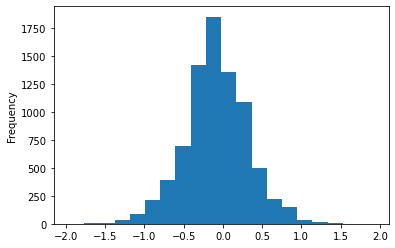

In [28]:
# add a log transformed version of the fr_en_prop, in this case something 10 times smaller in french than in 
# english will be -1, something 10 times larger will be 1. 
# distribution of the difference (log transform because proportions so .1-1-10 should be the same distance.)
# negative values french smaller than english, positive values english larger than french.
logged = np.log10(df.fr_en_prop)
logged.plot.hist(bins=20)

In [29]:
# df['log10fren'] = logged

In [30]:
gravity_df = df.copy()
gravity_df.drop(['geometry_A', 'geometry_B'], axis = 1, inplace=True)


In [31]:
# save the dummies version
file_name = "edges.csv"
fp = os.path.join(OUTDIR, file_name)
gravity_df.to_csv(fp, index = False, sep = ";")

## Create Edges

In [32]:
df.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,WEST,NORTH,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en,fr_en_prop,en_fr_prop
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814,0.852766,1.172655
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,1,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189,1.231004,0.812345
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,1,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827,1.039161,0.962315
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,1,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207,1.410848,0.708794
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,1,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664,1.229687,0.813215


In [33]:
# creates a shapely line object between the two city points
def create_edge(row):
    edge = LineString([row['geometry_A'], row['geometry_B']])
    return edge

In [34]:
# test line creation
df['geometry'] = df.apply(create_edge, axis = 1)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [35]:
df.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,NORTH,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en,fr_en_prop,en_fr_prop,geometry
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814,0.852766,1.172655,LINESTRING (3760015.3675289643 2889948.6954368...
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189,1.231004,0.812345,LINESTRING (3760015.3675289643 2889948.6954368...
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827,1.039161,0.962315,LINESTRING (3760015.3675289643 2889948.6954368...
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207,1.410848,0.708794,LINESTRING (3760015.3675289643 2889948.6954368...
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664,1.229687,0.813215,LINESTRING (3760015.3675289643 2889948.6954368...


In [36]:
# transform into a geodataframe
edge_df = gpd.GeoDataFrame(df, columns = df.columns, geometry = 'geometry', crs = gdf.crs)


<AxesSubplot:>

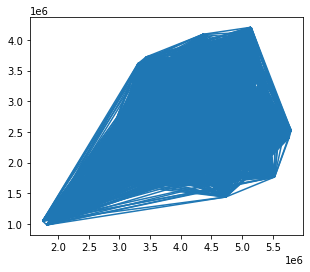

In [37]:
edge_df.plot()

In [38]:
edge_df.drop(['geometry_A', 'geometry_B'], axis = 1, inplace=True)

In [39]:
# save the edges map
fp = os.path.join(OUTDIR, "edges.shp")
edge_df.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_10804/4219909911.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edge_df.to_file(fp)


#### Save edges with no zeroes

In [40]:
# subset so collocations are all larger than 0
edge_df = edge_df[(edge_df.col_en > 0 ) & (edge_df.col_fr > 0)].copy()

In [41]:
# save the edges map
fp = os.path.join(OUTDIR, "edges_nz.shp")
edge_df.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_10804/23110852.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edge_df.to_file(fp)


In [42]:
# and as csv
nz_edge = edge_df.copy()
nz_edge.drop(['geometry'], axis = 1, inplace=True)

# save
fp = os.path.join(OUTDIR, "edges_nz.csv")
# nz_edge.to_csv(fp, sep = ";", index = False)

<div class="alert alert-block alert-warning">
<b>Add R predictions (run R notebook in between this)</b> 
</div>

In [43]:
df_new = pd.read_csv(fp, sep=';')
df_new.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,col_prop_en,fr_en_prop,en_fr_prop,log10fren,lang,lang_int,res_en2,res_fr2,pred_en2,pred_fr2
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,2.095814,0.852766,1.172655,-0.069170,BOTH,OTHER,0.935661,1.138099,9.057393,8.142979
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,0.325189,1.231004,0.812345,0.090259,FR,OTHER,0.545147,1.127986,7.584617,6.656904
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,0.756827,1.039161,0.962315,0.016683,FR,OTHER,1.615544,2.009756,7.358948,6.450443
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,0.320207,1.410848,0.708794,0.149480,FR,OTHER,0.552024,1.240146,7.562301,6.665664
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,0.229664,1.229687,0.813215,0.089795,FR,OTHER,0.419540,0.978479,7.362434,6.457549


In [44]:
df_new[['city_A', 'city_B']].iloc[7982] == edge_df[['city_A', 'city_B']].iloc[7982]

city_A    True
city_B    True
dtype: bool

In [45]:
df_new['res_en2'].isnull().sum()

0

In [46]:
# add to gdf
edge_df[['res_en2', 'res_fr2', 'pred_en2', 'pred_fr2']] = df_new[['res_en2', 'res_fr2', 'pred_en2', 'pred_fr2']].copy()

In [47]:
edge_df2 = pd.DataFrame(edge_df)

In [48]:
edge_df2['geometry'].copy().isnull().sum()

0

In [50]:
df2 = df_new[['city_A', 'city_B', 'distance', 'border_DUM', 'FR_con', 'EN_con', 'col_en', 'col_fr', 'col_prop_en', 'col_prop_fr', 'res_en2', 'res_fr2']].copy()


In [51]:
geometries = [geometry for geometry in edge_df2.geometry]

In [52]:
df2['geometry'] = geometries

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [53]:
df2['geometry'].copy().isnull().sum()

0

In [54]:
edge_df.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [55]:
df2 = gpd.GeoDataFrame(df2, crs = edge_df.crs, geometry = df2.geometry)

In [56]:
# save the edges map
fp = os.path.join(OUTDIR, "edges_nz2.shp")
df2.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_10804/860696546.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df2.to_file(fp)
